In [ ]:
!pip install statsmodels

    100% |████████████████████████████████| 6.2MB 257kB/s ta 0:00:011
    100% |████████████████████████████████| 235kB 5.7MB/s eta 0:00:01


In [ ]:
from IPython.display import IFrame
IFrame("report.pdf", width=1000, height=600)

In [ ]:
# !head 'SMSSpam' | cut -d"$'\t'" -f2 | sed 's/,/ , /g' | tr ' ' '\n' | sort | uniq -c | sort -rn | less

# Required Libs and Class

+ We implemented two different classes such as SMSBase, Util below cell.
+ Class SMSBase has common variables for different classification algorithms and deep learning approaches. That class will be extended by SMSClassification and SMSDL in the next cells.
+ Class Util has some helper methods to plot and display data and result.

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import spacy

import statsmodels.api as sm

from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

from sklearn.externals import joblib

import os.path

class SMSBase:
    # Spacy library is loading English dictionary.
    _nlp = spacy.load("en")
    
    def __init__(self, filename, frac=0.8):
        self._filename = filename
        self._features = ['class', 'context']
        
        self._df_raw = pd.read_csv(self._filename, sep='\t', names=self._features)
        self.__format_context()
        
        self.__extract_features()
        
        self._group_by_feature = self._df_raw .groupby('class')
        self._counts_by_features = self._group_by_feature.count().to_dict()['context']
        
        self.__split_test_train(frac)
        
    def __format_context(self):
        self._df_raw['context'] =  self._df_raw['context'].map(lambda text : text.rstrip())
        self._df_raw['context'] =  self._df_raw['context'].map(lambda text : text.replace(',', ' ,') if ',' in text else text)
    
    def __extract_features(self):
        self._df_raw['len']= self._df_raw['context'].map(lambda text : len(text))
        self._df_raw['n_words'] = self._df_raw['context'].map(lambda text : len(text.split(' ')))

        #updating features
        self._features = self._df_raw.columns
    
    def __split_test_train(self, frac):
        self._df_train = self._df_raw.sample(frac=frac)
        self._df_test = self._df_raw.drop(self._df_train.index)
    
    def describe(self):
        print('-' * 20 + 'Extended Dataset (Head)' + '-' * 20)
        display(self._df_raw.head())
        
        print('-' * 20 + 'Extended Dataset (Describe)' + '-' * 20)
        display(self._df_raw.describe())
        
        print('-' * 20 + 'Groupby Class (Describe)' + '-' * 20)
        display(self._group_by_feature.describe())
        
    def create_lemmas(self, c):
        tokens = self._nlp(c)
        return [token.lemma_ for token in tokens]
    
    def create_tokens(self, c):
        tokens = self._nlp(c)
        return [token for token in tokens]
    
    
class Util:
        
    def report_classification(model, df_train, df_test, X_features, y_feature):
        
        classes_train = np.unique(df_train[y_feature].values).tolist()
        classes_test = np.unique(df_test[y_feature].values).tolist()
        
        assert (classes_train == classes_test)
        
        classes = classes_train # The order of class is important!
        
        X_train = df_train[X_features].values.tolist()
        X_test = df_test[X_features].values.tolist()
        
        y_train = df_train[y_feature].values.tolist()
        y_test = df_test[y_feature].values.tolist()
        
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        report_cm(y_train, y_test, y_train_pred, y_test_pred, classes)
        
    def report_cm(y_train, y_test, y_train_pred, y_test_pred, classes):
        figure, axes = plt.subplots(1, 2, figsize=(10,5))

        cm_test = confusion_matrix(y_test, y_test_pred)
        df_cm_test = pd.DataFrame(cm_test, index = classes, columns = classes)
        ax = sns.heatmap(df_cm_test, annot=True, ax = axes[0], square= True)
        ax.set_title('Test CM')

        cm_train = confusion_matrix(y_train, y_train_pred)
        df_cm_train = pd.DataFrame(cm_train, index = classes, columns = classes)
        ax = sns.heatmap(df_cm_train, annot=True, ax = axes[1], square= True)
        ax.set_title('Train CM')

        print('-' * 20 + 'Testing Performance' + '-' * 20)
        print(classification_report(y_test, y_test_pred, target_names = classes))
        print('acc: ', metrics.accuracy_score(y_test, y_test_pred))

        print('-' * 20 + 'Training Performance' + '-' * 20)
        print(classification_report(y_train, y_train_pred, target_names = classes))
        print('acc: ', metrics.accuracy_score(y_train, y_train_pred))
        
    
    def plot_cdf(p, 
             ax, 
             deltax=None, 
             xlog=False, 
             xlim=[0, 1], 
             deltay=0.25, 
             ylog=False, 
             ylim=[0,1], 
             xlabel = 'x'):

        df = pd.DataFrame(p, columns=[xlabel])
        display(df.describe())
        
        ecdf = sm.distributions.ECDF(p)
        x = ecdf.x
        y = ecdf.y
        assert len(x) == len(y)
        if deltax is not None:
            x_ticks = np.arange(xlim[0], xlim[1] + deltax, deltax)
            ax.set_xticks(x_ticks)

        ax.set_xlabel(xlabel)
        ax.set_xlim(xlim[0], xlim[1])
        ax.vlines(np.mean(p), min(y), max(y), color='red', label='mean', linewidth=2)
        ax.vlines(np.median(p), min(y), max(y), color='orange', label='median', linewidth=2)
        ax.vlines(np.mean(p) + 2 * np.std(p), min(y), max(y), color='blue', label='mean + 2 * std', linewidth=2)
        ax.vlines(np.mean(p) + 3 * np.std(p), min(y), max(y), color='green', label='mean + 3 * std', linewidth=2)

        y_ticks = np.arange(ylim[0], ylim[1] + deltay, deltay)
        ax.set_ylabel('CDF')
        ax.set_yticks(y_ticks)
        ax.set_ylim(ylim[0], ylim[1])

        if xlog is True:
            ax.set_xscale('log')

        if ylog is True:
            ax.set_yscale('log')


        ax.grid(which='minor', alpha=0.5)
        ax.grid(which='major', alpha=0.9)

        ax.legend(loc=4)

        sns.set_style('whitegrid')
        sns.regplot(x=x, y=y, fit_reg=False, scatter=True, ax = ax)
    
        
    def plot_class_dist(df, by):
        
        x_features = df.columns.drop(by)
        assert 0 < len(x_features)
        
        x_features = x_features[0]
        dist = df.groupby(by)[x_features].size() / len(df)
        display(dist)        
        sns.barplot(x=dist.index, y=dist.values)
        
    def plot_boxplot(df, by, y, ax):
        ax = sns.boxplot(x=by, y=y, data=df[[by,  y]], ax = ax)
        ax.set_yscale('log')
        
    def dump_pickle(obj,filename):
        joblib.dump(obj, filename)
        
    def load_pickle(filename):
        return joblib.load(filename)

/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Introduction

In this assessment, we classify SMS corpus. SMS corpus consists of two columns such as label, context (message). Since data already has a target (labelled)  feature we can apply supervised machine learning algorithms. Before applying ML, we need to follow up those steps in the flowchart during this experiments.
<img src="ml_steps.png">

After these operations, we applied classification algorithms and deep learning. In the first part, you can find classification's experiment. In the next second part, you can find deep learning approach

## Part#1 - Classification
+ In this experiment, we used pipeline approaching to apply a bunch of different operations respectively on the data. The class of SMSClassfication has 3 different pipelines corresponding to different ML algorithms, such as;
    + Navie Bayes (NB), 
    + SVM, 
    + Random Forest Tree (RFT).
+ Before applying ML algorithms in each pipeline, we used TF-IDF to exract features over SMS corpus.
+ In SVM and Random Forest pipelining except for Naive Bayes, we used SVD (TruncatedSVD) to reduce of dimension (number of features) of data since we have limited computational resources (my personal laptop). So, we just focused on 50 features out of N. N denotes the number of unique words that appear in the corpus. Before we are creating the weights of the features on the bag-of-words by using TF-IDF, CountVectorizer is creating token counts as a sparse matrix.
+ In training step, we used GridSearchCV to find out the optimum hyperparameters. We used 10 fold cross validation on StratifiedKFold since it guarantees that the weight of class would be same with the original data in the each fold.

<img src="pipeline.png">

In [ ]:
class SMSClassification(SMSBase):
    __pipelines = {}
    __params = {}
    __format_model_file_name = '{}_model.pkl'

    def __init__(self, filename, frac=0.8):
        super().__init__(filename, frac)
        
        self.__bow = CountVectorizer(analyzer=self.create_lemmas)
        self.__tfidf = TfidfTransformer()
        
        self.__svd = TruncatedSVD(n_components=50)

        self.__cv = StratifiedKFold(n_splits=10)
        
        self.__default_params = {
            'tfidf__use_idf': (True, False),
            'bow__analyzer': (self.create_lemmas, self.create_tokens),
        }
        
        self.__X = self._df_train['context'].values.tolist()
        self.__y = self._df_train['class'].values.tolist()
        
   
    def __create_pipeline(self, option='NB'):
                        
        if (option in self.__pipelines) is False:
                        
            if option is 'NB':
                classifier = MultinomialNB()
                pipeline = Pipeline([
                    ('bow', self.__bow),
                    ('tfidf', self.__tfidf),
                    ('classifier', classifier),
                ])

            elif option is 'SVM':
                classifier = SVC()
                pipeline = Pipeline([
                    ('bow', self.__bow),
                    ('tfidf', self.__tfidf),
                    ('svd', self.__svd),
                    ('classifier', classifier),
                ])
                
            elif option is 'RFT':
                classifier = RandomForestClassifier()
                pipeline = Pipeline([
                    ('bow', self.__bow),
                    ('tfidf', self.__tfidf),
                    ('svd', self.__svd),
                    ('classifier', classifier),
                ])
                
            else:
                classifier = MultinomialNB()

            self.__pipelines[option] = pipeline
            
            return pipeline

        else:
            return self.__pipelines[option]
            
            
    def __create_grid_search_params(self, option='NB'):
        
        if (option in self.__params) is False:
            if option is 'SVM':
                params = [
                    {
                      'classifier__C': [1, 10, 100, 1000], 
                      'classifier__kernel': ['linear']
                    },
                    {
                      'classifier__C': [1, 10, 100, 1000], 
                      'classifier__gamma': [0.001, 0.0001], 
                      'classifier__kernel': ['rbf']
                    },
                ]

                # merging two list of paramaters on the same list.
#                 params = list(map(lambda m : {**m, **self.__default_params}, params))
            else:
                params = self.__default_params

            self.__params[option] = params
        else:
            params = self.__params[option]
            
        return params

        
        
    def validate(self, option='NB'):
        
        pipeline = self.__create_pipeline(option)
        if pipeline is not None:            
            scores = cross_val_score(pipeline, 
                                     self.__X, 
                                     self.__y, 
                                     scoring='accuracy', 
                                     cv=self.__cv, 
                                     verbose=1, 
                                     n_jobs=-1)

            print('scores={}\nmean={} std={}'.format(scores, scores.mean(), scores.std()))
        else:
            print ("pipeline does not exist!")

        
    def train(self, option='NB', dump=True):
        
        pipeline = self.__create_pipeline(option)
        if pipeline is not None:
            
            params = self.__create_grid_search_params(option)
            
            grid = GridSearchCV(
                pipeline, 
                params, 
                refit=True, 
                n_jobs=-1, 
                scoring='accuracy', 
                cv=self.__cv)

            model = grid.fit(self.__X, self.__y)
            
            display('(Grid Search) Best Parameters:', )
            display(pd.DataFrame([model.best_params_]))

            if dump:
                model_file_name = self.__format_model_file_name.format(option)
                Util.dump_pickle(model, model_file_name)
                
            return model
                
        else:
            print('pipeline does not exist!')
            return None

    
    def test(self, X=None, model=None, model_file=None):
        
        if X is None:
            X = self.__X
        
        if model is None and model_file is None:
            print('Please, use either model or model_file')
            return []
        
        if model_file is not None and os.path.isfile(model_file):
            model = Util.load_pickle(model_file)
            print('{} file was loaded'.format(model_file))
            return model.predict(X)
        
        if model is not None:
            return model.predict(X)
        else:
            return []

/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Data Exploring

In [ ]:
sms = SMSClassification('SMSSpam')

+ After loading data, to plot some statistical graphs (CDF, boxplot), we calculated lenght of each context and number of words, which appears in each context.
+ We calculated the distribution of classes which appear in the corpus. 

In [ ]:
sms.describe()

--------------------Extended Dataset (Head)--------------------


,class,context,len,n_words
0,ham,"Go until jurong point , crazy.. Available only...",112,21
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28
3,ham,U dun say so early hor... U c already then say...,49,11
4,ham,"Nah I don't think he goes to usf , he lives ar...",62,14


--------------------Extended Dataset (Describe)--------------------


,len,n_words
count,5572.000000,5572.000000
mean,80.811917,16.031407
std,60.273482,11.832019
min,2.000000,1.000000
25%,36.000000,7.000000
50%,62.000000,13.000000
75%,123.000000,24.000000
max,910.000000,175.000000


--------------------Groupby Class (Describe)--------------------


len                                                           \
        count        mean        std   min    25%    50%    75%    max   
class                                                                    
ham    4825.0   71.775337  58.783939   2.0   33.0   52.0   93.0  910.0   
spam    747.0  139.180723  29.067007  13.0  133.0  149.0  158.0  224.0   

      n_words                                                      
        count       mean        std  min   25%   50%   75%    max  
class                                                              
ham    4825.0  14.726010  11.974647  1.0   7.0  11.0  19.0  175.0  
spam    747.0  24.463186   6.001311  2.0  22.0  26.0  28.0   37.0

class
ham     0.865937
spam    0.134063
Name: context, dtype: float64

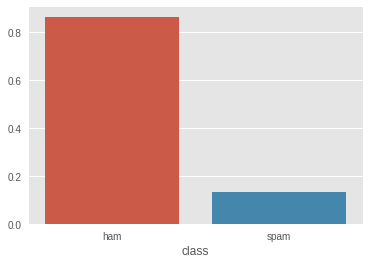

In [ ]:
Util.plot_class_dist(sms._df_raw, 'class')

+ According to the next graph CDF of number of words in context, 
    + 50% of the corpus consists of contexts which have less than 13 words.
    + 90% of the corpus consists of contexts which have less than roughly 32 words.
+ According to the next graph boxplot of number of words in context, 
    + The classes (ham, spam) have uniquely identified distribution, clearly.

,number of words
count,5572.000000
mean,16.031407
std,11.832019
min,1.000000
25%,7.000000
50%,13.000000
75%,24.000000
max,175.000000


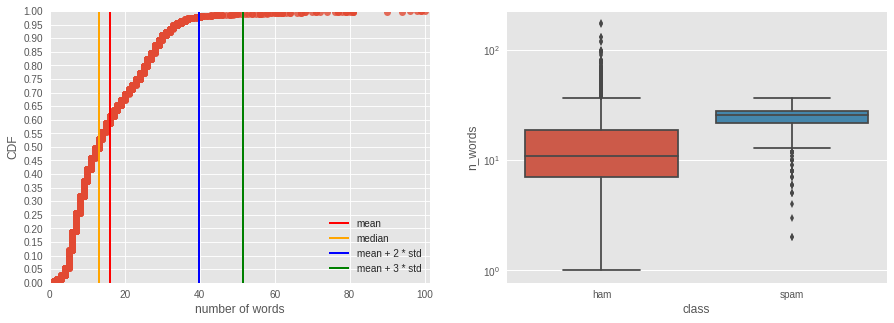

In [ ]:
n_words_in_context = sms._df_raw['n_words'].values.tolist()

figure, axes = plt.subplots(1, 2, figsize=(15,5))
Util.plot_cdf(n_words_in_context, 
         axes[0], 
         xlim=[0, np.mean(n_words_in_context) + 3 * np.std(n_words_in_context) + 50],
         deltay = 0.05,
         ylim=[0, 1.00], xlabel='number of words')

Util.plot_boxplot(sms._df_raw, 'class', 'n_words', axes[1])

+ According to the next graph CDF of length of words in context, 
    + 50% of the corpus consists of contexts whose length are less than roughly 62.
    + 90% of the corpus consists of contexts whose length are less than roughly 155.
+ According to the next graph boxplot of number of words in context, 
    + The classes (ham, spam) have uniquely identified distribution, clearly.

,len of context
count,5572.000000
mean,80.811917
std,60.273482
min,2.000000
25%,36.000000
50%,62.000000
75%,123.000000
max,910.000000


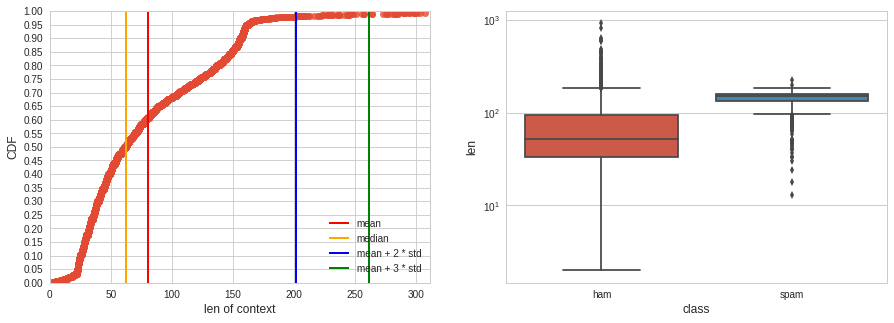

In [ ]:
len_of_context = sms._df_raw['len'].values.tolist()

figure, axes = plt.subplots(1, 2, figsize=(15,5))

Util.plot_cdf(len_of_context, 
         axes[0], 
         xlim=[0, np.mean(len_of_context) + 3 * np.std(len_of_context) + 50],
         deltay = 0.05,
         ylim=[0, 1.00], xlabel='len of context')

Util.plot_boxplot(sms._df_raw, 'class', 'len', axes[1])

+ Filtering context by minimum number of words == 1

In [ ]:
sms._df_raw[sms._df_raw['n_words'] == 1]['context'].values.tolist()

['Yup',
 'Thanx...',
 'Okie...',
 'Ok..',
 'Beerage?',
 'Ok...',
 'Ok...',
 'Ok...',
 'Ok...',
 '645',
 'Ok...',
 'Ok',
 'Ok.',
 'Ok...',
 'Okie...',
 'Yup...',
 'Ok...',
 'Okie',
 'Ok...',
 'Okie',
 'ALRITE',
 'Anything...',
 'Ok',
 'staff.science.nus.edu.sg/~phyhcmk/teaching/pc1323',
 'Ok...',
 ':)',
 'Ok.',
 'Nite...',
 'Ok.',
 'Okie',
 'Ok.',
 'Okie...',
 'G.W.R',
 'Ok',
 'Havent.',
 'Anytime...',
 'Ok...',
 'Okie',
 'Ok',
 'Yup']

+ Filtering context by mean number of words == 16

In [ ]:
sms._df_raw[sms._df_raw['n_words'] == 16]['context'].values.tolist()

['Even my brother is not like to speak with me. They treat me like aids patent.',
 "I'm back &amp; we're packing the car now , I'll let you know if there's room",
 "K fyi x has a ride early tomorrow morning but he's crashing at our place tonight",
 "Its not the same here. Still looking for a job. How much do Ta's earn there.",
 "I'm still looking for a car to buy. And have not gone 4the driving test yet.",
 'Text her. If she doesnt reply let me know so i can have her log in',
 'Busy here. Trying to finish for new year. I am looking forward to finally meeting you...',
 'Here is your discount code RP176781. To stop further messages reply stop. www.regalportfolio.co.uk. Customer Services 08717205546',
 'Hey so this sat are we going for the intro pilates only? Or the kickboxing too?',
 'From here after The performance award is calculated every two month.not for current one month period..',
 'Hmmm...k...but i want to change the field quickly da:-)i wanna get system administrator or network 

+ Filtering context by length of words == 18

In [ ]:
sms._df_raw[sms._df_raw['len'] == 18]['context'].values.tolist()

['Watching tv lor...',
 'Was the farm open?',
 "Annoying isn't it.",
 'Ok i juz receive..',
 'Okay... We wait ah',
 'At home by the way',
 'Wat r u doing now?',
 "Can... I'm free...",
 'Sorry. || mail? ||',
 'Wat u doing there?',
 'ringtoneking 84484',
 'Wat time ü finish?',
 'Thinking of u ;) x',
 'WHAT TIME U WRKIN?']

+ Filtering context by median length of words == 60

In [ ]:
sms._df_raw[sms._df_raw['len'] == 60]['context'].values.tolist()

['Yeah sure , give me a couple minutes to track down my wallet',
 'sorry , no , have got few things to do. may be in pub later.',
 'Today am going to college so am not able to atten the class.',
 'No no:)this is kallis home ground.amla home town is durban:)',
 'I want to show you the world , princess :) how about europe?',
 'Horrible gal. Me in sch doing some stuff. How come u got mc?',
 'Eat jap done oso aft ur lect wat... Ü got lect at 12 rite...',
 'Hai priya are you right. What doctor said pa. Where are you.',
 "Yes , i'm small kid.. And boost is the secret of my energy..",
 'Must come later.. I normally bathe him in da afternoon mah..',
 'Wish u many many returns of the day.. Happy birthday vikky..',
 'Hiya , had a good day? Have you spoken to since the weekend?',
 'Sorry da thangam , very very sorry i am held up with prasad.',
 'I want to be there so i can kiss you and feel you next to me',
 'Yar lor... Keep raining non stop... Or u wan 2 go elsewhere?',
 'Thank u. IT BETTER WORK

## Validation Stage

+ In validation stage, we applied 3 different pipelining without choosing sufficient parameters on our SMS corpus, respectively. So, as you see the results in the next cell, SVM performing the worst performance against the other classification algorithms (Naive Bayes and Random Forest) since we used default parameters.
+ We took a look at their cross validation scores and performances, as well

In [ ]:
classifiers = ['NB', 'SVM', 'RFT']

In [ ]:
for c in classifiers:
    display('-' * 40 + c + '-' * 40)
    %time sms.validate(c)

'----------------------------------------NB----------------------------------------'

scores=[ 0.95302013  0.95973154  0.95067265  0.94170404  0.95515695  0.9573991
  0.94157303  0.94157303  0.94831461  0.93932584]
mean=0.9488470930132291 std=0.007070744329841395
CPU times: user 512 ms, sys: 220 ms, total: 732 ms
Wall time: 23.9 s


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   23.5s finished


'----------------------------------------SVM----------------------------------------'

scores=[ 0.86353468  0.86353468  0.8632287   0.8632287   0.8632287   0.8632287
  0.86516854  0.86741573  0.86741573  0.86966292]
mean=0.8649647070785018 std=0.002242201227467186
CPU times: user 476 ms, sys: 160 ms, total: 636 ms
Wall time: 25.7 s


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   25.3s finished


'----------------------------------------RFT----------------------------------------'

scores=[ 0.97315436  0.95973154  0.95515695  0.9529148   0.96860987  0.97085202
  0.95730337  0.96404494  0.94831461  0.96629213]
mean=0.961637459450704 std=0.007820617806919379
CPU times: user 444 ms, sys: 164 ms, total: 608 ms
Wall time: 25.9 s


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   25.7s finished


## Training Stage

+ In training stage, we applied 3 different pipelining with GridSearchCV on our SMS corpus, respectively.
+ In training stage, to use the optimum hyperparameters subsequently in testing stage, they were picked by using GridSearchCV, underneath.
+ After selecting the optimum hyperparameters, each model corresponding to each pipepline was saved in binary format as a pickle file. To test any instance on any model, those binary files can be used after applying deserialization, easily

In [ ]:
models = {}

for c in classifiers:
    display('-' * 40 + c + '-' * 40)
    %time models[c] = sms.train(c)

'----------------------------------------NB----------------------------------------'

'(Grid Search) Best Parameters:'

,bow__analyzer,tfidf__use_idf
0,<bound method SMSBase.create_lemmas of <__main...,True


CPU times: user 7.15 s, sys: 364 ms, total: 7.52 s
Wall time: 2min 30s


'----------------------------------------SVM----------------------------------------'

'(Grid Search) Best Parameters:'

,classifier__C,classifier__kernel
0,100,linear


CPU times: user 6.42 s, sys: 944 ms, total: 7.36 s
Wall time: 2min 32s


'----------------------------------------RFT----------------------------------------'

'(Grid Search) Best Parameters:'

,bow__analyzer,tfidf__use_idf
0,<bound method SMSBase.create_lemmas of <__main...,True


CPU times: user 7.83 s, sys: 1.16 s, total: 8.99 s
Wall time: 3min 18s


## Testing Stage

+ In testing stage, we tested each pipelining on our test data that we already splitted into over binary (pickle) file we generated in training stage.

In [ ]:
for c in classifiers:
    display('-' * 40 + c + '-' * 40)
    model_file = '{}_model.pkl'.format(c)
    %time r = sms.test(model_file=model_file)
    display(r)

'----------------------------------------NB----------------------------------------'

NB_model.pkl file was loaded
CPU times: user 4.45 s, sys: 12 ms, total: 4.46 s
Wall time: 4.46 s


array(['ham', 'ham', 'ham', ..., 'ham', 'ham', 'ham'], 
      dtype='<U4')

'----------------------------------------SVM----------------------------------------'

SVM_model.pkl file was loaded
CPU times: user 3.94 s, sys: 0 ns, total: 3.94 s
Wall time: 3.94 s


array(['ham', 'ham', 'ham', ..., 'ham', 'ham', 'ham'], 
      dtype='<U4')

'----------------------------------------RFT----------------------------------------'

RFT_model.pkl file was loaded
CPU times: user 3.98 s, sys: 8 ms, total: 3.98 s
Wall time: 3.98 s


array(['ham', 'ham', 'ham', ..., 'ham', 'ham', 'ham'], 
      dtype='<U4')

## Performance Evaluation

+ In this stage, we check out our performance evaluation by using confusion matrix. We used different metrics, such as precision, recall, f1 score and accuracy.

+ We also take care about number of True Positive (TP), True Negative (TN), False Positive (FP), False Negative (FN) on the confusion matrix.

+ NB is giving the best results according to precision metric on spam labels on top of test data. Because, your ham sms is not labelled spam at all. The classification is completely working well if we are focusing the number of FP (ham vs. spam). Nobody don't want to come across the relevant (ham) SMS in their spam box. Therefore, the precision of spam is important for that case because it has the best precision metric (1.00). 

    + Precision = TP / (TP + FP)
    + Recall = TP / (TP + FN)
    + Accuracy = (TP + TN) / (TP + TN + FP + FN)
    + F1 = 2 \* Precision \* Recall / (Precision + Recall)
    
        
| (Actual)/Pred. |  Ham | Spam |
|---|---|---|
|  Ham | TN  |  FP |
|  Spam | FN  | TP |

+ If we are focusing on the recall metric, some people won't want to see any spam SMS in their inbox. That case may get also annoying. However, it is not a big problem like the previous case (number of FP, precision). According to recall metric on spam labels on top of test data, SVM is giving the best results since it has the highest recall result (0.81).


'----------------------------------------NB----------------------------------------'

--------------------Testing Performance--------------------
             precision    recall  f1-score   support

        ham       0.95      1.00      0.97       965
       spam       1.00      0.63      0.77       149

avg / total       0.95      0.95      0.95      1114

acc:  0.950628366248
--------------------Training Performance--------------------
             precision    recall  f1-score   support

        ham       0.96      1.00      0.98      3860
       spam       1.00      0.75      0.86       598

avg / total       0.97      0.97      0.97      4458

acc:  0.967025572005


'----------------------------------------SVM----------------------------------------'

--------------------Testing Performance--------------------
             precision    recall  f1-score   support

        ham       0.97      0.99      0.98       965
       spam       0.95      0.81      0.87       149

avg / total       0.97      0.97      0.97      1114

acc:  0.968581687612
--------------------Training Performance--------------------
             precision    recall  f1-score   support

        ham       0.98      0.99      0.98      3860
       spam       0.92      0.87      0.90       598

avg / total       0.97      0.97      0.97      4458

acc:  0.97285778376


'----------------------------------------RFT----------------------------------------'

--------------------Testing Performance--------------------
             precision    recall  f1-score   support

        ham       0.96      0.99      0.97       965
       spam       0.95      0.70      0.81       149

avg / total       0.96      0.96      0.95      1114

acc:  0.955116696589
--------------------Training Performance--------------------
             precision    recall  f1-score   support

        ham       1.00      1.00      1.00      3860
       spam       1.00      0.98      0.99       598

avg / total       1.00      1.00      1.00      4458

acc:  0.99730820996


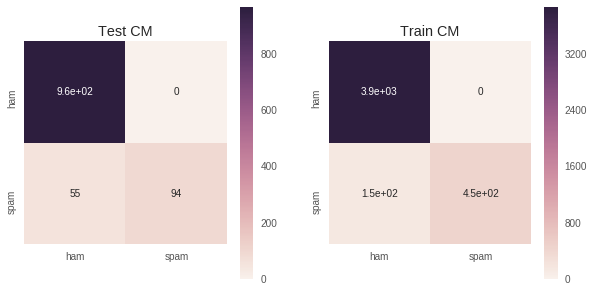

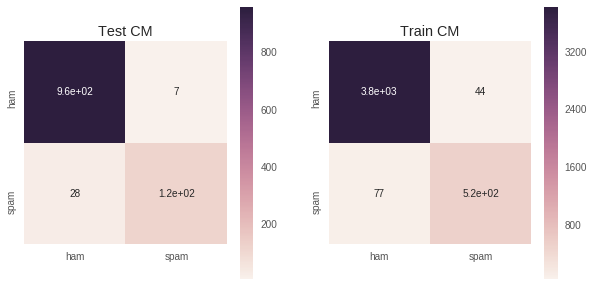

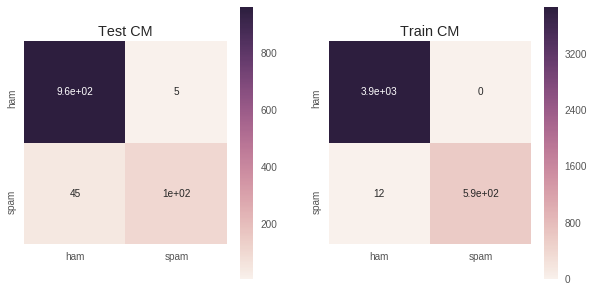

In [ ]:
for c in classifiers:
    display('-' * 40 + c + '-' * 40)
    model_file = '{}_model.pkl'.format(c)
    model = Util.load_pickle(model_file)
    Util.report_classification(model, 
                               sms._df_train, 
                               sms._df_test, 
                               'context', 
                               'class')

## Part#2 - Classifying SMS by using Deep Learning with RNN (LSTM)

+ In this part, we applied deep learning, additionally.
+ We implemented class SMSDL which is extending from SMSBase, above. This class has some bunch of methods to create word2vec model over our SMS corpus, and build deep learning layers.
+ During this experiment,
    + To build a ML model based on Deep Learning, we used Keras API and its backend is Tensorflow.
    + To apply NLP technique, we used Spacy libs rather than NLTK, again.
    + To create word2vec model and embedding vector before applying deep learning, we used Gensim libs instead of using TF-IDF. We could use Google's, GloVe's, Spacy's pre-trained vectors. However, we built our word2vec model since we have domain specific data based on SMS.
        + Google's pre-trained vectors based on GoogleNews
        + GLoVe's pre-trained vectors based on Wikipages
        + Spacy pre-trained vectors
        
+  We built a deep learning network by using the layers, respectively. We connected each other layer as you see in the graph, below. 
    + Embedding Layer
    + Dense Layer
    + LSTM for RNN Layer
    + Dense Layer   
    
<img src="deeplearning.png">

In [ ]:
import gensim, logging

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.models import Sequential

from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras import models

class SMSDL(SMSBase):
    
    # To implement a processing chain, some global variables were used.
    __clean_tokens = None
    __clean_corpus = None
    __word2vec = None
    __tokenizer = None
    __x_train_token_padded_seqs = None  # pad_sequences
    __x_test_token_padded_seqs = None  # pad_sequences
    __embedding_matrix = None
    __nn_layers = None
    
    # To create word2vec, the parameters are used in Gensim, below.
    # There are a few different approaching like the below instead of creating our word2vec model,
    # + Google's pre-trained vectors based on GoogleNews
    # + GLoVe's pre-trained vectors based on Wikipages
    # + Spacy pre-trained vectors
    __embedding_dim = 300
    __window = 15
    __workers = 4
    __cbow_mean = 1
    __alpha = 0.05
    
    # Creating file names for models with respect to given parameters, above.
    __format_word2vec_model = 'emb_dim:{}_window:{}_cbow:{}_apha:{}.bin'
    __word2vec_file = __format_word2vec_model.format(__embedding_dim, __window, __cbow_mean, __alpha)

    # Creating an embedding matrix using by word2vec model and the parameters, below
    __embedding_vector_length = 300
    __max_nb_words = 200000
    __max_input_length = 50

    # Deep Learning Layers' parameters are using to build a deep network. Our network consists of the layers, below:
    # + Embedding Layer
    # + Dense Layer
    # + LSTM for RNN Layer
    # + Dense Layer
    __num_lstm = 100
    __num_dense = 300
    __rate_drop_out = 0.1
    __rate_drop_lstm = float(0.15 + np.random.rand() * 0.25)
    __rate_drop_dense = float(0.15 + np.random.rand() * 0.25)

    # Creating file names for models with respect to given parameters, above.
    __format_dl_model = 'lstm_%d_%d_%.2f_%.2f.h5'
    __model_dl_file = __format_dl_model % (__num_lstm, __num_dense, __rate_drop_lstm, __rate_drop_dense)

    # In training step, those parameters are using, below.
    __number_of_epochs = 100
    __batch_size = 2048
    __validation_split = 0.1
    __shuffle = True
    
    def __init__(self, filename, frac=0.8):
        super().__init__(filename, frac)
        
        self.__x_name = 'context'
        self.__y_name = 'class'
        
        self.__label_classes = {'ham':0, 'spam':1}
        self.__num_classes = len(self.__label_classes)
        self.__encode_labels()
        
        self.__split_sentence_by_lemmas()
        self.__split_sentence_by_tokens()
            

    def __split_sentence_by_lemmas(self):
        self.__sentences_by_lemmas = list(map(lambda c : self.create_lemmas(c), self._df_raw[self.__x_name].values.tolist()))

    def __split_sentence_by_tokens(self):
        self.__sentences_by_tokens = list(map(lambda c : self.create_tokens(c), self._df_raw[self.__x_name].values.tolist()))

    def __encode_labels(self):
        # https://keras.io/utils/#to_categorical
        encoded_list = list(map(lambda c : self.__label_classes[c], self._df_train[self.__y_name].values.tolist()))
        self.__y_train_one_hot = to_categorical(encoded_list, self.__num_classes)
        
    def __create_word2vec(self, by='lemmas'):
        
        if not os.path.exists(self.__word2vec_file) or self.__word2vec is None:
            if by is 'lemmas':
                sentences = self.__sentences_by_lemmas
            elif by is 'tokens':
                sentences = self.__sentences_by_tokens
            else:
                print('You picked wrong function. Please, check your parameter you are using')
                return
            
            logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
            
            print('{} doesn\'t exist. A new word2vec is being built...'.format(self.__word2vec_file))
            
            self.__word2vec = gensim.models.Word2Vec(sentences,
                                                    size=self.__embedding_dim,
                                                    window=self.__window,
                                                    workers=self.__workers,
                                                    cbow_mean=self.__cbow_mean,
                                                    alpha=self.__alpha)
            self.__word2vec.save(self.__word2vec_file)

        elif self.__word2vec is not None:
            print('{} has already loaded for word2vec...'.format(self.__word2vec_file))
        else:
            print('{} is loading for word2vec...'.format(self.__word2vec_file))
            self.__word2vec = gensim.models.Word2Vec.load(self.__word2vec_file)
        
    def __create_tokenizer(self):
        
        self.__x_train_corpus = self._df_train[self.__x_name].values.tolist() 
        self.__x_test_corpus = self._df_test[self.__x_name].values.tolist()
        
        all_corpus = self.__x_train_corpus + self.__x_test_corpus

        print('x_train_corpus: {}'.format(len(self.__x_train_corpus)))
        print('x_test_corpus: {}'.format(len(self.__x_test_corpus)))

        # https://keras.io/preprocessing/text/#tokenizer
        self.__tokenizer = Tokenizer(num_words=self.__max_nb_words)
        self.__tokenizer.fit_on_texts(all_corpus)

        print('Found %s unique tokens' % len(self.__tokenizer.word_index))


    def __create_sequences(self):

        # https://keras.io/preprocessing/text/#text_to_word_sequence
        x_train_token_seqs = self.__tokenizer.texts_to_sequences(self.__x_train_corpus)
        x_test_token_seqs = self.__tokenizer.texts_to_sequences(self.__x_test_corpus)

        print('x_train_token_seqs: {}'.format(len(x_train_token_seqs)))
        print('x_test_token_seqs: {}'.format(len(x_test_token_seqs)))
        
        # https://keras.io/preprocessing/sequence/#pad_sequences
        self.__x_train_token_padded_seqs = pad_sequences(x_train_token_seqs, maxlen=self.__max_input_length)
        self.__x_test_token_padded_seqs = pad_sequences(x_test_token_seqs, maxlen=self.__max_input_length)
        print('x_train_token_padded_seqs: {}'.format(self.__x_train_token_padded_seqs.shape))
        print('x_test_token_padded_seqs: {}'.format(self.__x_test_token_padded_seqs.shape))

    def __create_embedding_matrix(self):
        
        token_index = self.__tokenizer.word_index
        self.__number_words = min(self.__max_nb_words, len(token_index)) + 1
        
        self.__embedding_matrix = np.zeros((self.__number_words, self.__embedding_vector_length))
        for word, i in token_index.items():
            if word in self.__word2vec.wv.vocab:
                self.__embedding_matrix[i] = self.__word2vec.wv.word_vec(word)

        print('Null word embeddings: %d' % np.sum(np.sum(self.__embedding_matrix, axis=1) == 0))
        print('embedding_matrix: {}'.format(self.__embedding_matrix.shape))
        
    def __init_weights(self, shape, dtype=None):
        print('init_weights shape: {}'.format(shape))
        # assert  shape == embedding_matrix.shape
        return self.__embedding_matrix

    def __create_embedding_layer(self):
        
        # https://keras.io/layers/embeddings/
        embedding = Embedding(self.__number_words,
                                self.__embedding_vector_length,
                                input_length=self.__max_input_length,
                                mask_zero=True,
                                embeddings_initializer=self.__init_weights)
        
        return embedding

    
    def __create_nn_layers(self, weights_filename=None):

        if self.__nn_layers is None:

            self.__nn_layers = Sequential()
            self.__nn_layers.add(self.__create_embedding_layer())

            # https://keras.io/layers/core/#dense
            # https://keras.io/layers/core/#activation
            self.__nn_layers.add(Dense(self.__num_dense, activation='sigmoid'))
            self.__nn_layers.add(Dropout(self.__rate_drop_out))

            # https://keras.io/layers/recurrent/
            self.__nn_layers.add(LSTM(self.__num_lstm, 
                               dropout=self.__rate_drop_lstm, 
                               recurrent_dropout=self.__rate_drop_lstm))
            
            self.__nn_layers.add(Dense(self.__num_classes, activation='softmax'))

            # https://keras.io/metrics/
            self.__nn_layers.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
            
            self.__nn_layers.summary()
        
        if weights_filename is not None:
            self.__nn_layers.load_weights(weights_filename)

    def __build_model(self, weights_filename=None):

        self.__create_word2vec()
        self.__create_tokenizer()
        self.__create_sequences()
        self.__create_embedding_matrix()
        self.__create_nn_layers(weights_filename)

    def __create_callbacks(self, tensorboard):

        callbacks = []
        # https://keras.io/callbacks/#usage-of-callbacks
        early_stopping = EarlyStopping(monitor='val_acc', patience=10)

        print(self.__model_dl_file)
        # https://keras.io/callbacks/#modelcheckpoint
        model_checkpoint = ModelCheckpoint(self.__model_dl_file, save_best_only=True)

        # https://keras.io/callbacks/#tensorboard
        if tensorboard:
            tensor_board = TensorBoard(log_dir='./logs',
                                       histogram_freq=5,
                                       write_graph=True,
                                       write_images=True,
                                       embeddings_freq=0,
                                       embeddings_layer_names=None,
                                       embeddings_metadata=None)
            callbacks.append(tensor_board)

        callbacks.append(early_stopping)
        callbacks.append(model_checkpoint)

        return callbacks
    
    def load_model(self, filename):
        model = models.load_model(filename)
        return model

    def train(self, tensorboard_enable=False):

        self.__build_model()

        callbacks = self.__create_callbacks(tensorboard_enable)

        # https://keras.io/models/model/
        self._model = self.__nn_layers.fit(self.__x_train_token_padded_seqs,
                             self.__y_train_one_hot,
                             epochs=self.__number_of_epochs,
                             batch_size=self.__batch_size,
                             validation_split=self.__validation_split,
                             shuffle=self.__shuffle,
                             callbacks=callbacks)

        best_val_score = max(self._model.history['val_acc'])
        print('Best Score by val_acc: {}'.format(best_val_score))
        
        self.__df_history = pd.DataFrame()
        self.__df_history['acc'] = self._model.history['acc']
        self.__df_history['loss'] = self._model.history['loss']
        self.__df_history['val_acc'] = self._model.history['val_acc']
        self.__df_history['val_loss'] = self._model.history['val_loss']
        
    
    def __test(self, X_token_padded_seqs):
        prediction_probs = self.__nn_layers.predict(X_token_padded_seqs,
                                             batch_size=self.__batch_size,
                                             verbose=1)

        pre_label_ids = list(map(lambda probs: probs.argmax(), list(prediction_probs)))
        classes = ['ham', 'spam']
    
        return list(map(lambda x: classes[x], pre_label_ids))        
    
            
    def test(self, X_token_padded_seqs=None, weights_filename=None):
        self.__build_model(weights_filename=weights_filename)
        
        if X_token_padded_seqs is None:
            return self.__test(self.__x_test_token_padded_seqs)
        else:
            return self.__test(X_token_padded_seqs)
        
    def __test2(self, X_token_padded_seqs, model):
        prediction_probs = model.predict(X_token_padded_seqs,
                                             batch_size=self.__batch_size,
                                             verbose=1)

        pre_label_ids = list(map(lambda probs: probs.argmax(), list(prediction_probs)))
        classes = ['ham', 'spam']

        return list(map(lambda x: classes[x], pre_label_ids))  
    
    def report_cm2(self, model):        
        X_train = self.__x_train_token_padded_seqs
        X_test = self.__x_test_token_padded_seqs
        
        y_train = self._df_train[self.__y_name].values.tolist()
        y_test = self._df_test[self.__y_name].values.tolist()
        
        y_train_pred = self.__test2(self.__x_train_token_padded_seqs, model)
        y_test_pred = self.__test2(self.__x_test_token_padded_seqs, model)
        
        classes = ['ham', 'spam']
        
        Util.report_cm(y_train, y_test, y_train_pred, y_test_pred, classes)
    
    def report_cm(self, weights_filename):
        self.__build_model(weights_filename)
        
        X_train = self.__x_train_token_padded_seqs
        X_test = self.__x_test_token_padded_seqs
        
        y_train = self._df_train[self.__y_name].values.tolist()
        y_test = self._df_test[self.__y_name].values.tolist()
        
        y_train_pred = self.__test(self.__x_train_token_padded_seqs)
        y_test_pred = self.__test(self.__x_test_token_padded_seqs)
        
        classes = ['ham', 'spam']
        
        Util.report_cm(y_train, y_test, y_train_pred, y_test_pred, classes)

    def display_history(self):
        display(self.__df_history.describe())
        
    def plot_acc(self):
        self.__df_history[['acc', 'val_acc']].plot()
        
    def plot_loss(self):
        self.__df_history[['loss', 'val_loss']].plot()


In [ ]:
sms_dl = SMSDL('SMSSpam')

+ After we splitted messeage into tokens by using Keras' tokenizer, we plotted CDF graph for frequency of unique words.
+ According to that graph, 
    + the unique words that appear less than 50 times in 95% of the corpus.
    + the unique words that appear less than 1 time in the 50% of the corpus.
    + the unique words that appear less than 4 times in the 75% of the corpus.

,freq of unique words
count,9009.000000
mean,9.834832
std,62.019317
min,1.000000
25%,1.000000
50%,1.000000
75%,4.000000
max,2361.000000


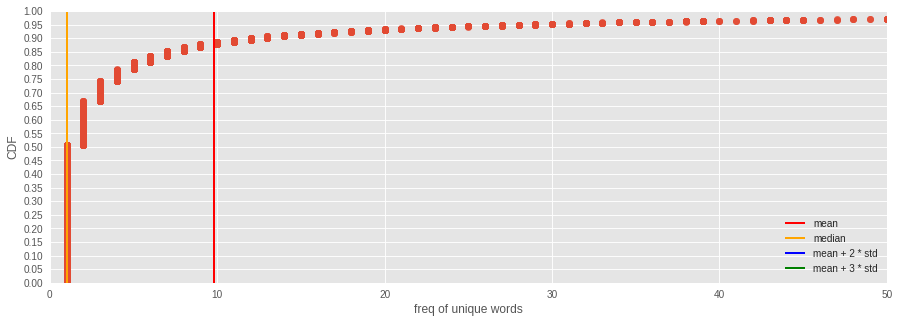

In [ ]:
tokenizer = sms_dl._SMSDL__tokenizer
freq_of_unique_words = list(map(lambda x : x[1], tokenizer.word_counts.items()))

figure, axes = plt.subplots(1, figsize=(15,5))
Util.plot_cdf(freq_of_unique_words, 
              axes,
              xlim = [0, 50],
              deltay = 0.05,
              ylim = [0, 1.00], xlabel='freq of unique words')

+ After creating a word2vec model, we check top10 similarity of a few arbitrary words that would be spam keys over our word2vec as you can see in the next table.

In [ ]:
sim = {}
sample_words = ['phone', 'sms', 'bank', 
                'call', 'discount', 'off', 
                'award', 'winner', 'free', 
                'text', 'cash', 'money', 
                'credit', 'prize', 'insurance', 
                'sale', 'click', 'subscriber', 
                '%', '$', 'pound']

for w in sample_words:
    sim[w] = sms_dl._SMSDL__word2vec.most_similar(w)

pd.DataFrame(sim).applymap(lambda x: '{} : {:.2f}'.format(x[0], float(x[1]))).T

,0,1,2,3,4,5,6,7,8,9
$,january : 0.99,g : 0.98,th : 0.98,% : 0.98,bank : 0.98,fyi : 0.98,dollar : 0.98,feb : 0.98,ten : 0.97,ish : 0.97
%,january : 0.98,$ : 0.98,gt : 0.98,bank : 0.98,murder : 0.98,th : 0.98,your : 0.97,face : 0.97,g : 0.97,@ : 0.97
award,select : 1.00,£ : 0.99,draw : 0.99,bonus : 0.99,show : 0.99,reward : 0.99,receive : 0.99,800 : 0.98,prize : 0.98,attempt : 0.98
bank,dollar : 0.99,$ : 0.98,th : 0.98,feb : 0.98,% : 0.98,january : 0.98,past : 0.97,gt : 0.97,fyi : 0.97,kill : 0.96
call,0800 : 0.93,customer : 0.92,please : 0.92,mobile : 0.92,08712300220 : 0.91,arrive : 0.91,claim : 0.91,camera : 0.90,line : 0.90,from : 0.90
cash,t&cs : 1.00,150ppm : 0.99,sae : 0.99,subscriber : 0.99,000 : 0.98,winner : 0.98,900 : 0.98,1000 : 0.98,collection : 0.98,operator : 0.98
click,credit : 0.99,direct : 0.99,connect : 0.99,inclusive : 0.99,www.comuk.net : 0.99,member : 0.99,hot : 0.99,services : 0.99,unsub : 0.99,player : 0.99
credit,inclusive : 0.99,www.comuk.net : 0.99,click : 0.99,services : 0.99,december : 0.99,unsub : 0.99,hot : 0.99,200 : 0.99,< : 0.99,account : 0.99
discount,quote : 0.99,digital : 0.99,150 : 0.99,85023 : 0.99,ipod : 0.99,choose : 0.99,chance : 0.99,hmv : 0.99,app : 0.99,official : 0.99
free,handset : 0.97,rental : 0.96,min : 0.96,t&c : 0.96,mobile : 0.96,network : 0.96,uk : 0.95,london : 0.95,txt : 0.95,camera : 0.95


## Training Stage (Deep Learning)
+ We use validation accuracy as an early stopping in our implementation. When it gets the highest accuracy, it will be check the next 10 epoch (patience).

In [ ]:
sms_dl.train()

2017-09-04 17:24:58,869 : INFO : collecting all words and their counts
2017-09-04 17:24:58,870 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-09-04 17:24:58,896 : INFO : collected 8544 word types from a corpus of 104594 raw words and 5572 sentences
2017-09-04 17:24:58,897 : INFO : Loading a fresh vocabulary
2017-09-04 17:24:58,905 : INFO : min_count=5 retains 1727 unique words (20% of original 8544, drops 6817)
2017-09-04 17:24:58,906 : INFO : min_count=5 leaves 94271 word corpus (90% of original 104594, drops 10323)
2017-09-04 17:24:58,912 : INFO : deleting the raw counts dictionary of 8544 items
2017-09-04 17:24:58,914 : INFO : sample=0.001 downsamples 64 most-common words
2017-09-04 17:24:58,915 : INFO : downsampling leaves estimated 62143 word corpus (65.9% of prior 94271)
2017-09-04 17:24:58,916 : INFO : estimated required memory for 1727 words and 300 dimensions: 5008300 bytes
2017-09-04 17:24:58,926 : INFO : resetting layer weights
2017-09-04 17:

emb_dim:300_window:15_cbow:1_apha:0.05.bin doesn't exist. A new word2vec is being built...


2017-09-04 17:24:59,549 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-09-04 17:24:59,571 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-09-04 17:24:59,581 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-09-04 17:24:59,592 : INFO : worker thread finished; awaiting finish of 0 more threads
2017-09-04 17:24:59,593 : INFO : training on 522970 raw words (310570 effective words) took 0.6s, 499450 effective words/s
2017-09-04 17:24:59,597 : INFO : saving Word2Vec object under emb_dim:300_window:15_cbow:1_apha:0.05.bin, separately None
2017-09-04 17:24:59,599 : INFO : not storing attribute syn0norm
2017-09-04 17:24:59,602 : INFO : not storing attribute cum_table
2017-09-04 17:24:59,680 : INFO : saved emb_dim:300_window:15_cbow:1_apha:0.05.bin


x_train_corpus: 4458
x_test_corpus: 1114
Found 9009 unique tokens
x_train_token_seqs: 4458
x_test_token_seqs: 1114
x_train_token_padded_seqs: (4458, 50)
x_test_token_padded_seqs: (1114, 50)
Null word embeddings: 7375
embedding_matrix: (9010, 300)
init_weights shape: (9010, 300)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 300)           2703000   
_________________________________________________________________
dense_3 (Dense)              (None, 50, 300)           90300     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 300)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 202   

In [ ]:
sms_dl.display_history()

,acc,loss,val_acc,val_loss
count,28.000000,28.000000,28.000000,28.000000
mean,0.940086,0.145030,0.949952,0.139811
std,0.094867,0.169571,0.056867,0.132794
min,0.528290,0.010197,0.852018,0.046070
25%,0.905533,0.022527,0.905269,0.053173
50%,0.983300,0.055283,0.984305,0.061012
75%,0.993519,0.257297,0.986547,0.249363
max,0.997757,0.687664,0.991031,0.449868


## Plotting Accuracy and Learning Curves
+ Plotting accuracy curves and learning curves for training and validation stage with respect to accuracy and loss.

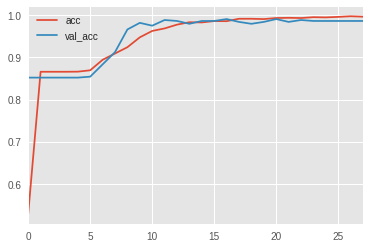

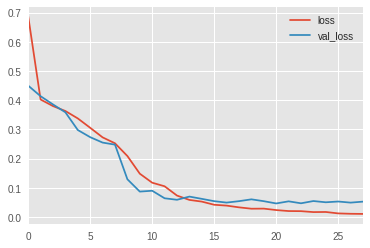

In [ ]:
sms_dl.plot_acc()
sms_dl.plot_loss()

## Performance Evalution
+ As you recall, we discussed two different important metrics (precision and recall) in classification apporaches.
+ The both of them have to be high as possible as to cover two different cases. 
+ According to our expectations, deep learning approach is giving reasonable and optimal results in terms of precision an recall metrics on spam labes on top of test data.
+ It has the highest accuracy than the other classification algortihms (Naive Bayes, SVM, Random Forest) we already applied since we take care about sequence of word in each message sematically. TF-IDF is not performing well to cover that requirement.


emb_dim:300_window:15_cbow:1_apha:0.05.bin has already loaded for word2vec...
x_train_corpus: 4458
x_test_corpus: 1114
Found 9009 unique tokens
x_train_token_seqs: 4458
x_test_token_seqs: 1114
x_train_token_padded_seqs: (4458, 50)
x_test_token_padded_seqs: (1114, 50)
Null word embeddings: 7375
embedding_matrix: (9010, 300)
1114/1114 [==============================] - 1s
--------------------Testing Performance--------------------
             precision    recall  f1-score   support

        ham       0.99      1.00      0.99       971
       spam       0.97      0.95      0.96       143

avg / total       0.99      0.99      0.99      1114

acc:  0.99012567325
--------------------Training Performance--------------------
             precision    recall  f1-score   support

        ham       1.00      1.00      1.00      3854
       spam       0.99      0.98      0.98       604

avg / total       1.00      1.00      1.00      4458

acc:  0.995513683266


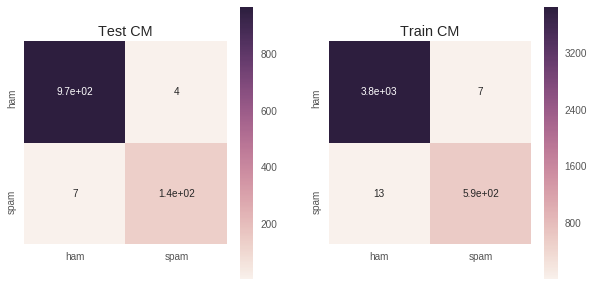

In [ ]:
sms_dl.report_cm('lstm_100_300_0.33_0.30.h5')

In [ ]:
# sms_dl._SMSDL__nn_layers.save('model.h5')
# model = sms_dl.load_model('model.h5')
# sms_dl.report_cm2(model)